In [1]:
import os, io
from pathlib import Path
import math
from collections import defaultdict
from itertools import chain
import sqlite3

from tqdm.notebook import tqdm
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageOps

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from hdc import *

In [2]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

xp = cupy


In [3]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

ensure_dataset_folder()

if 0 == 1:
    print(f'Cleaning "{config.dataset_path}"')
    removed = []
    
    for fn in os.listdir(config.dataset_path):
        if fn.endswith(".db"):
            fn = os.path.join(config.dataset_path, fn)
            os.remove(fn)
            removed.append(fn)

    print(f'Removed .db files: {','.join(removed)}')

hdv_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name), autocommit=False)

In [4]:
dataset_source = os.path.join(config.dataset_source)

In [5]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 143 ms, sys: 86.7 ms, total: 230 ms
Wall time: 229 ms


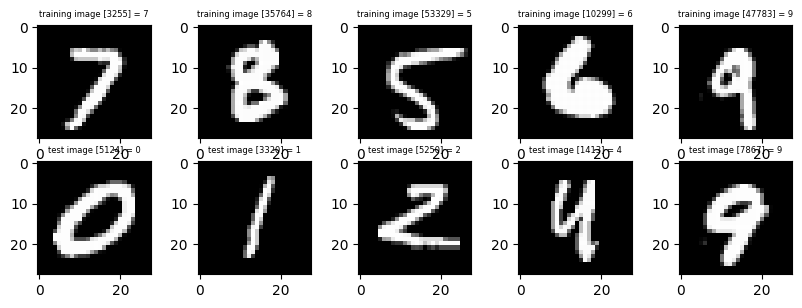

In [6]:
%%time
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [277]:
# SENSOR_RECEPTIVE_FIELD_SIZES = [8, 12, 16, 20, 24, 28, 32, 36, 40]
SENSOR_RECEPTIVE_FIELD_SIZES = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE ** 2 # no. of sensors within each group
SENSOR_GROUPS_COUNT = 256


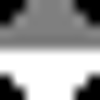
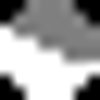
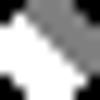
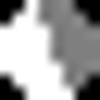
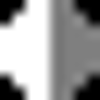
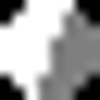
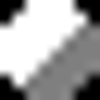
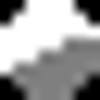
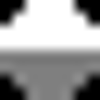
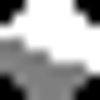
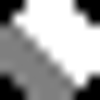
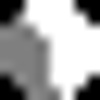
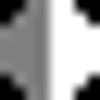
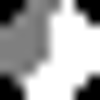
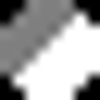
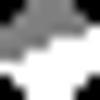

In [278]:
SENSOR_GROUPS_IMG = defaultdict(list) # key - sensor receptive field size, value - list of sensor images
captions = defaultdict(list)
sz = config.sample_size

for receptive_field_size in SENSOR_RECEPTIVE_FIELD_SIZES:
    for sensor_no in range(SENSOR_GROUP_SQUARE):
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        draw.ellipse([0, 0, receptive_field_size - 1, receptive_field_size - 1], outline=0, fill=127, width=0)
        angle = sensor_no * 360 / SENSOR_GROUP_SQUARE
        draw.chord([0, 0, receptive_field_size - 1, receptive_field_size - 1], angle, angle + 180, outline=255, fill=255)
        captions[receptive_field_size].append(f'#{sensor_no} ({sensor_no // SENSOR_GROUP_SIZE}, {sensor_no % SENSOR_GROUP_SIZE})')
        SENSOR_GROUPS_IMG[receptive_field_size].append(canvas)

first_size = SENSOR_RECEPTIVE_FIELD_SIZES[0]
first_image_list = SENSOR_GROUPS_IMG[first_size]
first_caption_list = captions[first_size]
display_images_grid(list(map(lambda x: x.crop([0,0,first_size,first_size]).resize((100, 100)), first_image_list)), 
                    captions=first_caption_list,
                    col_count=SENSOR_GROUP_SIZE)

In [279]:
# Turn grayscale images to numpy arrays with weights which balance positive and negative areas
SENSOR_GROUPS = np.zeros((len(SENSOR_RECEPTIVE_FIELD_SIZES), SENSOR_GROUP_SQUARE, config.sample_size, config.sample_size), dtype=float)

for i, receptive_field_size in enumerate(SENSOR_RECEPTIVE_FIELD_SIZES):
    assert receptive_field_size in SENSOR_GROUPS_IMG.keys()
    imgs = SENSOR_GROUPS_IMG[receptive_field_size]
    sensor_group_for_this_receptive_field_size = np.array(list(map(np.array, imgs))).astype(float)
    SENSOR_GROUPS[i] = sensor_group_for_this_receptive_field_size
    
shape_save = SENSOR_GROUPS.shape
SENSOR_GROUPS = SENSOR_GROUPS.reshape(-1, config.sample_size ** 2)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
SENSOR_GROUPS[SENSOR_GROUPS==255] = 1
counts_of_positives = (SENSOR_GROUPS == 1).sum(axis=1)
counts_of_negatives = (SENSOR_GROUPS == 127).sum(axis=1)
white_image = np.ones(SENSOR_GROUPS.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    SENSOR_GROUPS[i][SENSOR_GROUPS[i] == 127] = -1 * (p / n)
    v = SENSOR_GROUPS[i] @ white_image
    assert np.isclose(v, 0), v

SENSOR_GROUPS = SENSOR_GROUPS.reshape(shape_save)
SENSOR_GROUPS = xp_array_to_gpu(SENSOR_GROUPS)
SENSOR_GROUPS.shape, np.unique_counts(xp_array_from_gpu(SENSOR_GROUPS))

((10, 16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.34615385, -1.30952381, -1.26086957, -1.25925926,
        -1.25581395, -1.24      , -1.23529412, -1.22413793, -1.2125    ,
        -1.20895522, -1.18811881, -1.18518519, -1.17857143, -1.17391304,
        -1.17142857, -1.16666667, -1.15555556, -1.15384615, -1.15      ,
        -1.14492754, -1.13253012, -1.12765957, -1.1147541 , -1.11320755,
        -1.11111111, -1.10526316, -1.1047619 , -1.08490566, -1.08450704,
        -1.08333333, -1.08235294, -1.08      , -1.07407407, -1.06382979,
        -1.05405405, -1.04761905, -1.0462963 , -1.03636364, -1.03448276,
        -1.03333333, -1.02739726, -1.02020202, -1.        ,  0.        ,
         1.        ]), counts=array([     44,     104,      84,     138,     162,     172,     100,
             68,     348,     160,     134,     202,     324,     112,
            184,     210,     456,     360,     208,     240,     276,
            332,     376,     244,     106,      72,  

In [280]:
SENSOR_GROUP_AREAS = (SENSOR_GROUPS.reshape(SENSOR_GROUPS.shape[0], SENSOR_GROUPS.shape[1], -1) == 1).sum(axis=2) # number of ON pixels for each receptor
SENSOR_GROUP_AREAS.shape, SENSOR_GROUP_AREAS, SENSOR_GROUP_AREAS.mean(), SENSOR_GROUP_AREAS.min(), SENSOR_GROUP_AREAS.max(), SENSOR_GROUP_AREAS.std()

((10, 16),
 array([[ 26,  27,  29,  28,  26,  28,  29,  27,  26,  29,  29,  30,  26,
          30,  29,  29],
        [ 35,  31,  34,  33,  35,  33,  34,  31,  35,  33,  34,  34,  35,
          34,  34,  33],
        [ 38,  39,  41,  40,  38,  40,  41,  39,  38,  41,  41,  42,  38,
          42,  41,  41],
        [ 54,  50,  52,  52,  54,  52,  52,  50,  54,  52,  52,  55,  54,
          55,  52,  52],
        [ 56,  57,  60,  58,  56,  58,  60,  57,  56,  59,  60,  62,  56,
          62,  60,  59],
        [ 71,  66,  69,  68,  71,  68,  69,  66,  71,  68,  69,  71,  71,
          71,  69,  68],
        [ 74,  75,  79,  77,  74,  77,  79,  75,  74,  77,  79,  81,  74,
          81,  79,  77],
        [ 96,  90,  94,  92,  96,  92,  94,  90,  96,  92,  94,  97,  96,
          97,  94,  92],
        [100, 101, 106, 104, 100, 104, 106, 101, 100, 105, 106, 108, 100,
         108, 106, 105],
        [119, 113, 116, 115, 119, 115, 116, 113, 119, 115, 116, 120, 119,
         120, 116, 115]]

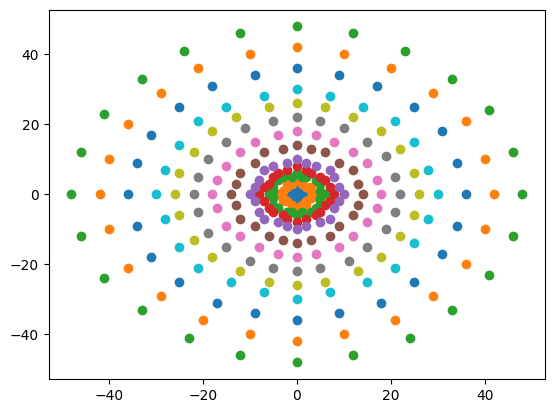

In [281]:
radiuses = [2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 36, 42, 48]
rotations = 24
rotation_transfs = []

for i in range(rotations):
    theta = (2 * math.pi / rotations) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

rotation_transfs = np.array(rotation_transfs)

for radius in radiuses:
    arrow = np.array([radius, 0, 0])
    arrow_positions = (rotation_transfs @ arrow).astype(int)
    arrow_positions = set([(ap[0], ap[1]) for ap in arrow_positions])
    arrow_positions = list(arrow_positions)
    xs = list(map(lambda ap: ap[0], arrow_positions))
    ys = list(map(lambda ap: ap[1], arrow_positions))
    plt.scatter(xs, ys)

plt.show()

In [350]:
class SensorGroupDistributor(object):
    def __call__(self, sensor_group_index):
        return None

class SensorGroupDistributor_Grid(SensorGroupDistributor):
    def __init__(self):
        self.s = int(np.sqrt(SENSOR_GROUPS_COUNT))
        assert self.s ** 2 == SENSOR_GROUPS_COUNT
        
    def __call__(self, sensor_group_index):
        field_size_index = 0 
        field_size = SENSOR_RECEPTIVE_FIELD_SIZES[field_size_index]
        x = (sensor_group_index % self.s) * field_size
        y = (sensor_group_index // self.s) * field_size 
        return x, y, field_size, field_size_index

class SensorGroupDistributor_ConcentricCircles(SensorGroupDistributor):
    def __init__(self):
        self.half_sample_size = config.sample_size // 2
        # radiuses = [2, 4, 6, 8, 11, 16, 21, 26, 34, 42, 56, 59]
        # rotations = 24
        radiuses = list(range(6, 52, 6))
        rotations = 36
        rotation_transfs = []
        
        for i in range(rotations):
            theta = (2 * math.pi / rotations) * i
            cos_theta = math.cos(theta)
            sin_theta = math.sin(theta)
            transf = [
                [cos_theta, sin_theta, 0],
                [-sin_theta, cos_theta, 0],
                [0, 0, 1]
            ]
            rotation_transfs.append(np.array(transf))
        
        rotation_transfs = np.array(rotation_transfs)
        self.points = []
        self.field_sizes = [] 
        
        for radius_index, radius in enumerate(radiuses):
            arrow = np.array([radius, 0, 0])
            arrow_positions = (rotation_transfs @ arrow).astype(int)
            arrow_positions += self.half_sample_size
            arrow_positions = set([(ap[0], ap[1]) for ap in arrow_positions])
            self.points.extend(list(arrow_positions))
            field_size = int(len(SENSOR_RECEPTIVE_FIELD_SIZES) * radius_index / len(radiuses))
            self.field_sizes.extend([field_size] * len(arrow_positions))

        assert len(self.field_sizes) == len(self.points)
        
    def __call__(self, sensor_group_index):
        field_size_index = self.field_sizes[sensor_group_index]
        # field_size_index = self.field_sizes[0]
        field_size = SENSOR_RECEPTIVE_FIELD_SIZES[field_size_index]
        x, y = self.points[sensor_group_index]
        x_offset = x - field_size // 2
        y_offset = y - field_size // 2
        x_offset = max(0, min(x_offset, config.sample_size - field_size - 1))
        y_offset = max(0, min(y_offset, config.sample_size - field_size - 1))
        return x_offset, y_offset, field_size, field_size_index

class SensorGroupDistributor_2d_Gauss(SensorGroupDistributor):
    def __init__(self):
        self.half_sample_size = config.sample_size // 2
        self.max_radius = np.linalg.norm((self.half_sample_size, self.half_sample_size)) # max distance from center to corner
        self.mean = [0, 0]
        self.cov = [[self.half_sample_size, 0], [0, self.half_sample_size]]  # spherical covariance
        self.unique_xy_pairs = set()
        
    def __call__(self, sensor_group_index):
        for _ in range(10000):
            x, y = np.random.multivariate_normal(self.mean, self.cov, 1).T * 4
            x = int(x[0])
            y = int(y[0])
    
            if x < -self.half_sample_size or x >= self.half_sample_size or y < -self.half_sample_size or y >= self.half_sample_size:
                continue
    
            point_radius = np.linalg.norm((x, y))
            x = x + self.half_sample_size
            y = y + self.half_sample_size
            assert x >= 0 and x < config.sample_size
            assert y >= 0 and y < config.sample_size
            assert point_radius <= self.max_radius
    
            # field_size_index = 0
            field_size_index = int(len(SENSOR_RECEPTIVE_FIELD_SIZES) * point_radius / self.max_radius)
            assert field_size_index >= 0 and field_size_index < len(SENSOR_RECEPTIVE_FIELD_SIZES)
    
            field_size = SENSOR_RECEPTIVE_FIELD_SIZES[field_size_index]
            radius = field_size // 2
            
            if x > config.sample_size - radius or x < radius:
                continue
    
            if y > config.sample_size - radius or y < radius:
                continue
    
            if (x, y) in self.unique_xy_pairs:
                continue
    
            self.unique_xy_pairs.add((x, y))
            return x - radius, y - radius, field_size, field_size_index
        else:
            assert False, 'Failed to draw suitable x, y, radius within given attempts'

In [363]:
RETINA_SENSOR_GROUP_INFOS = pd.DataFrame(columns=['group_index', 'field_size_index', 'x_offset', 'y_offset', 'receptive_field_size'])
retina = xp.zeros((SENSOR_GROUPS_COUNT, SENSOR_GROUP_SQUARE, config.sample_size, config.sample_size))
distr = SensorGroupDistributor_Grid()
# distr = SensorGroupDistributor_2d_Gauss()
# distr = SensorGroupDistributor_ConcentricCircles()

for i in range(SENSOR_GROUPS_COUNT):
    x_offset, y_offset, field_size, field_size_index = distr(i)
    assert x_offset >= 0 and x_offset <= config.sample_size - field_size, (x_offset, field_size)
    assert y_offset >= 0 and y_offset <= config.sample_size - field_size, (y_offset, field_size)
    
    for g in range(SENSOR_GROUP_SQUARE):
        receptor_plane = retina[i, g]
        assert y_offset <= receptor_plane.shape[0] - field_size, (y_offset, receptor_plane.shape[0], field_size) # make sure we don't roll too much
        assert x_offset <= receptor_plane.shape[1] - field_size, (x_offset, receptor_plane.shape[1], field_size) # with points wrapped around axes
        sensor_at_place = SENSOR_GROUPS[field_size_index, g]
        sensor_at_place = xp.roll(sensor_at_place, y_offset, axis=0)
        sensor_at_place = xp.roll(sensor_at_place, x_offset, axis=1)
        receptor_plane[:] = sensor_at_place
        
    RETINA_SENSOR_GROUP_INFOS.loc[len(RETINA_SENSOR_GROUP_INFOS)] = [
        i, # index_within_retina
        field_size_index,
        x_offset,
        y_offset,
        field_size
    ]

RETINA_COMBINED = retina.reshape((-1, config.sample_size ** 2))
RETINA_POS = RETINA_COMBINED.copy()
RETINA_NEG = RETINA_COMBINED.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

RETINA_SENSOR_GROUP_AREAS = xp.zeros((SENSOR_GROUPS_COUNT, SENSOR_GROUP_SQUARE))

for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
    sensor_group_index = sensor_group_info['group_index']
    field_size_index = sensor_group_info['field_size_index']
    RETINA_SENSOR_GROUP_AREAS[sensor_group_index] = SENSOR_GROUP_AREAS[field_size_index]

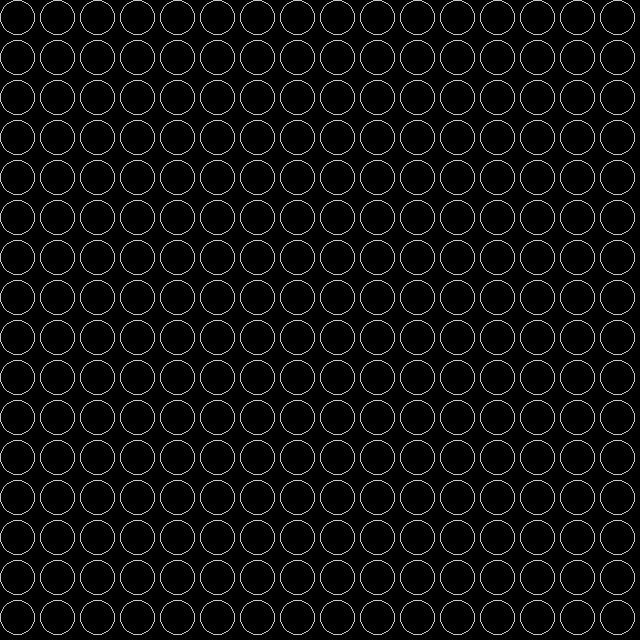

In [364]:
# df_centers = pd.DataFrame(columns=['x', 'y'])
sz = int(np.sqrt(RETINA_COMBINED.shape[1]))
assert sz * sz == RETINA_COMBINED.shape[1]
k = 5
retina_map = Image.new('L', (sz * k, sz * k), color=0)
retina_map_draw = ImageDraw.Draw(retina_map)

for i in range(RETINA_COMBINED.shape[0]):
    receptor_plane = xp_array_from_gpu(RETINA_COMBINED[i])
    receptor_plane = receptor_plane.reshape((sz, sz))
    receptor_plane *= receptor_plane # get rid of -1 
    vert = np.argwhere(receptor_plane.sum(axis=1) != 0).ravel() # project non-zero pixels on Y axis
    horz = np.argwhere(receptor_plane.sum(axis=0) != 0).ravel() # project non-zero pixels on X axis
    vert_lo = vert[0]
    vert_hi = vert[-1]
    horz_lo = horz[0]
    horz_hi = horz[-1]
    center_x = int(k * (horz_lo + horz_hi) / 2)
    center_y = int(k * (vert_lo + vert_hi) / 2)
    radius = int(k * max((vert_hi - vert_lo), (horz_hi - horz_lo)) / 2)
    assert radius <= 100, radius
    retina_map_draw.circle((center_x, center_y), radius, width=1, outline=200)
    # df_centers.loc[len(df_centers)] = [center_x, center_y]

retina_map


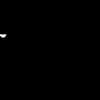
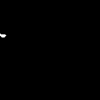
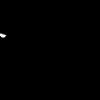
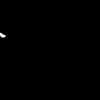
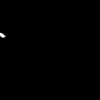
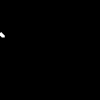
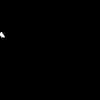
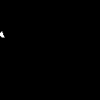
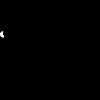
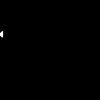
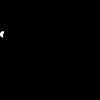
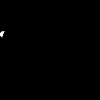
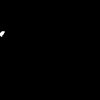
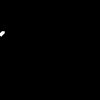
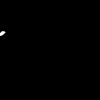
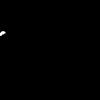
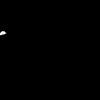
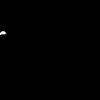
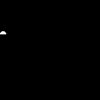
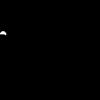
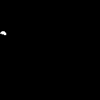
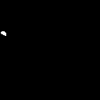
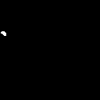
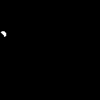
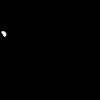
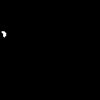
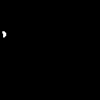
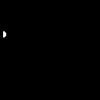
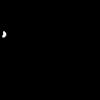
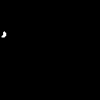
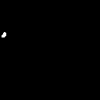
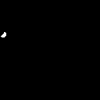
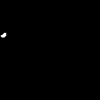
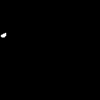
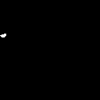
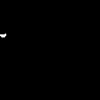

In [365]:
# For each sensor group we prepare bunch of specific samples (measured in steps here)
SPECIFIC_SAMPLES_IMG = defaultdict(list) # key - sensor group index, value - list of specific images
sz = config.sample_size
steps = 360 // 10 # 10 degrees

for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
    sensor_group_index = sensor_group_info['group_index']
    x_offset = sensor_group_info['x_offset'] # where sensor group
    y_offset = sensor_group_info['y_offset'] # is located on retina
    receptive_field_size = sensor_group_info['receptive_field_size']
    
    for i in range(steps):
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        angle = i * 360 / steps
        draw.chord([x_offset, y_offset, x_offset + receptive_field_size - 1, y_offset + receptive_field_size - 1], angle, angle + 180, outline=255, fill=255)
        SPECIFIC_SAMPLES_IMG[sensor_group_index].append(canvas)

sensor_group_index_to_show = RNG.choice(list(SPECIFIC_SAMPLES_IMG.keys()))
images_to_show = SPECIFIC_SAMPLES_IMG[sensor_group_index_to_show]
display_images_grid(list(map(lambda x: x.resize((100, 100)), images_to_show)), col_count=int(np.sqrt(steps)))

In [366]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images):
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    sense_area = (RETINA_POS @ image_masks.T).T # for check of illuminated area (number of illuminated pixels)
    sense_level = (RETINA_POS @ images.T).T # for check of absolute illumination
    sense_neg_level = (RETINA_NEG @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        # Per image cycle
        # sense_area_i -> matrix: row=sensor group, column=number of illuminated pixels for each receptor in this group
        sense_area_i = sense_area_i.reshape(-1, SENSOR_GROUP_SQUARE)  
        cond1 = (sense_area_i / RETINA_SENSOR_GROUP_AREAS) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)

        # sense_level_i -> matrix: row=sensor group, column=sum of illimination on positive part of each receptor
        sense_level_i = sense_level_i.reshape(-1, SENSOR_GROUP_SQUARE)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * RETINA_SENSOR_GROUP_AREAS) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)

        # sense_neg_level_i -> matrix: row=sensor group, column=sum of illimination on negative part of each receptor
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [367]:
SPECIFIC_SAMPLES_REACTIONS = dict()

for sensor_group_index, specific_samples_img in tqdm(SPECIFIC_SAMPLES_IMG.items()):
    specific_samples_img = xp.array(specific_samples_img)
    specific_samples_img = specific_samples_img.reshape(specific_samples_img.shape[0], -1)
    reactions = xp_array_from_gpu(sense_images(specific_samples_img))
    SPECIFIC_SAMPLES_REACTIONS[sensor_group_index] = np.array(reactions)

SPECIFIC_SAMPLES_REACTIONS[0].shape

  0%|          | 0/256 [00:00<?, ?it/s]

(36, 4096)

In [368]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [369]:
def lay_grid(image, step=16):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


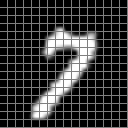
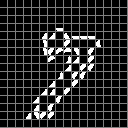

In [374]:
images = []
captions = []

image_index = RNG.choice(len(x_train))
# image_index = 14265
random_img_data = x_train[image_index]
random_img = Image.frombytes('L', size=(28, 28), data=random_img_data)
random_img = random_img.resize((config.sample_size, config.sample_size))
images.append(random_img)
captions.append(f'#{image_index}')

random_img_arr = xp.array([random_img])
random_img_arr = random_img_arr.reshape(1, -1)
random_img_receptors = xp_array_from_gpu(sense_images(random_img_arr))
random_img_receptors_dims = random_img_receptors.shape[1]
random_img_receptors = random_img_receptors.reshape(SENSOR_GROUPS_COUNT, -1)
assert (random_img_receptors == 1).sum() > 0
sz = config.sample_size
sensor_map_image = np.zeros((sz, sz))

best_is = set()
layers = []

for sensor_group_index, sensor_group in enumerate(random_img_receptors):
    assert sensor_group.shape == (SENSOR_GROUP_SQUARE, )
    speficic_samples_reactions_for_sensor_group = SPECIFIC_SAMPLES_REACTIONS[sensor_group_index]
    
    if np.any(sensor_group > 0):
        # Find most similar reaction among specific samples of reactions for given sensor group
        a = np.zeros(random_img_receptors_dims)
        assert a.shape[0] == speficic_samples_reactions_for_sensor_group.shape[1]
        a[sensor_group_index * SENSOR_GROUP_SQUARE:sensor_group_index * SENSOR_GROUP_SQUARE + SENSOR_GROUP_SQUARE] = sensor_group
        a = a / np.linalg.norm(a)
        b = speficic_samples_reactions_for_sensor_group
        b = (b.T / np.linalg.norm(b, axis=1)).T
        cos_sim = (a @ b.T)
        best_i = np.argmax(cos_sim)
        best_is.add((sensor_group_index, best_i))
        most_similar_specific_sample = np.array(SPECIFIC_SAMPLES_IMG[sensor_group_index][best_i])
        assert most_similar_specific_sample.shape == (sz, sz)
        layers.append(most_similar_specific_sample)

for layer in layers:
    sensor_map_image += layer
    
sensor_map_image[sensor_map_image != 0] = 255
images.append(Image.frombytes('L', (sz, sz), data=(sensor_map_image).ravel().astype('b')))
captions.append('')

lay_grid_local = lambda i: lay_grid(i, 8)
display_images(list(map(lay_grid_local, images)), captions=captions)


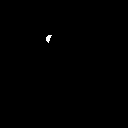
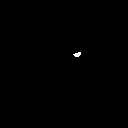
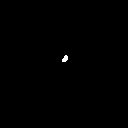
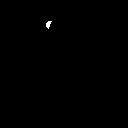
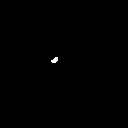
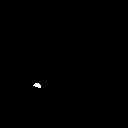
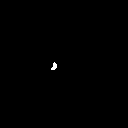
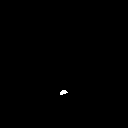
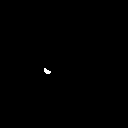
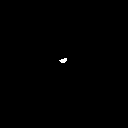
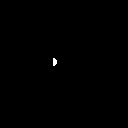
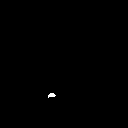
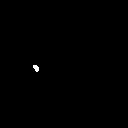
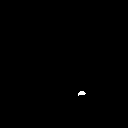
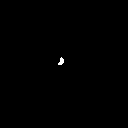
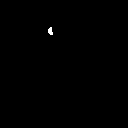
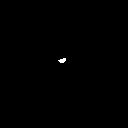
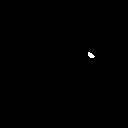
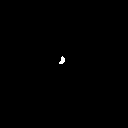
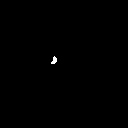
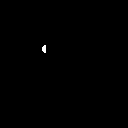
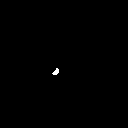
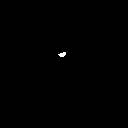
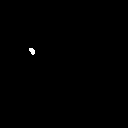
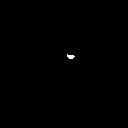
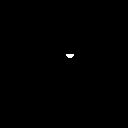
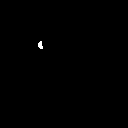
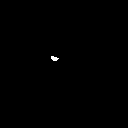
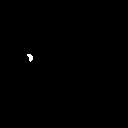
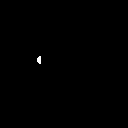
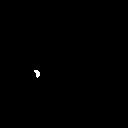
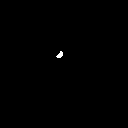
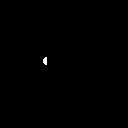
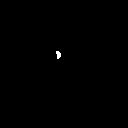
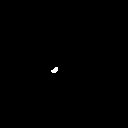
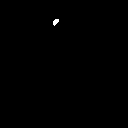
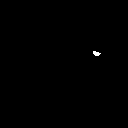
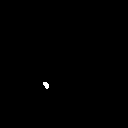
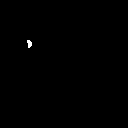
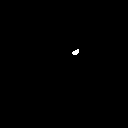
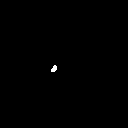
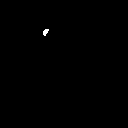
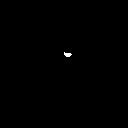
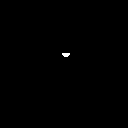
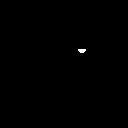
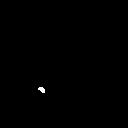
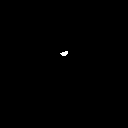
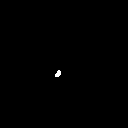
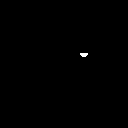
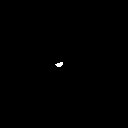
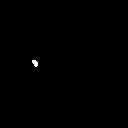
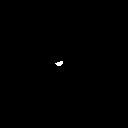
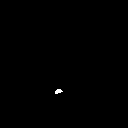
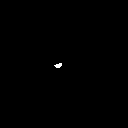
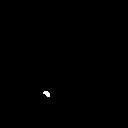
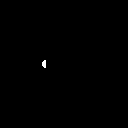
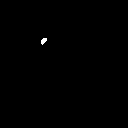
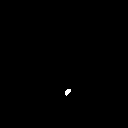
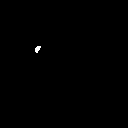
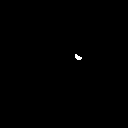
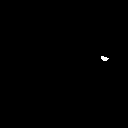
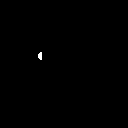
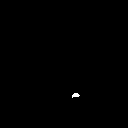
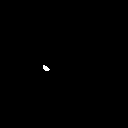
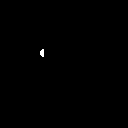
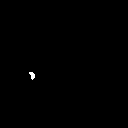
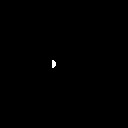
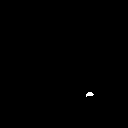
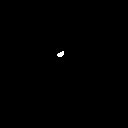
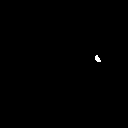
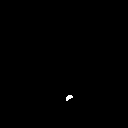
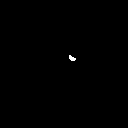
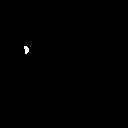
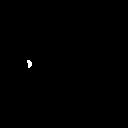
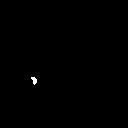
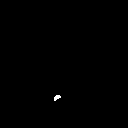
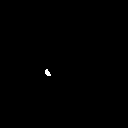
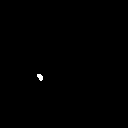
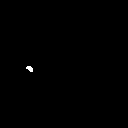
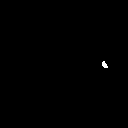
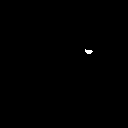

In [342]:
images = []

for sensor_group_index, i in best_is:
    images_to_show = SPECIFIC_SAMPLES_IMG[sensor_group_index][i]
    images.append(images_to_show)
    
display_images_grid(images, col_count=8)

In [48]:
def get_grid_offsets(lo, hi):
    assert hi > lo
    points = []
    rng = range(lo, hi + 1)
    
    for i in rng:
        for j in rng:
            if i == 0 and j == 0:
                continue
                
            points.append((i,j))
    
    return np.array(points)

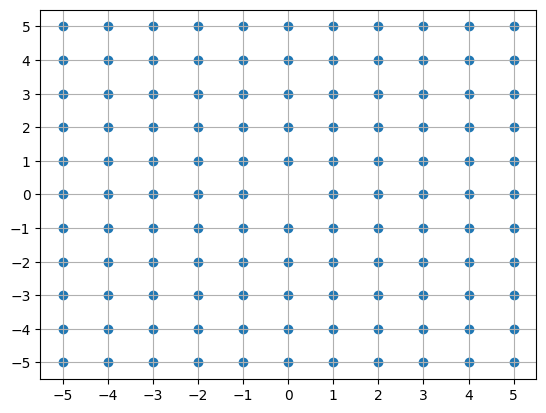

(120, 2)

In [49]:
points = get_grid_offsets(-5, 5)
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.min(points[:,0]), np.max(points[:,0]) + 1, 1))
plt.yticks(range(np.min(points[:,1]), np.max(points[:,1]) + 1, 1))
plt.grid()
plt.show()
points.shape

In [50]:
def get_clock_offsets(radiuses):
    assert np.all(np.array(radiuses) > 0)
    hours = 12
    rotation_transfs = []
    
    for i in range(hours):
        theta = (2 * math.pi / hours) * i
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        transf = [
            [cos_theta, sin_theta, 0],
            [-sin_theta, cos_theta, 0],
            [0, 0, 1]
        ]
        rotation_transfs.append(np.array(transf))
    
    rotation_transfs = np.array(rotation_transfs)
    points = dict()
    
    for radius in radiuses:
        arrow = np.array([radius, 0, 0])
        arrow_positions = (rotation_transfs @ arrow).astype(int)
        # duplicates handling
        arrow_positions_codes = [''.join(map(str, ap)) for ap in arrow_positions]
        points.update(zip(arrow_positions_codes, arrow_positions))
    
    if '000' in points: 
        del points['000']

    return np.array(list(points.values()))[:,0:2]

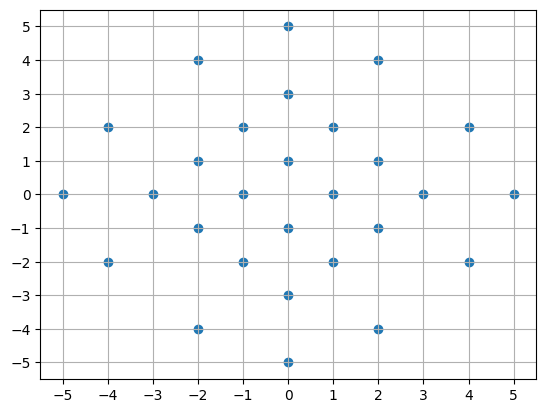

(28, 2)

In [51]:
radiuses = [5, 3, 1]
points = get_clock_offsets(radiuses)
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

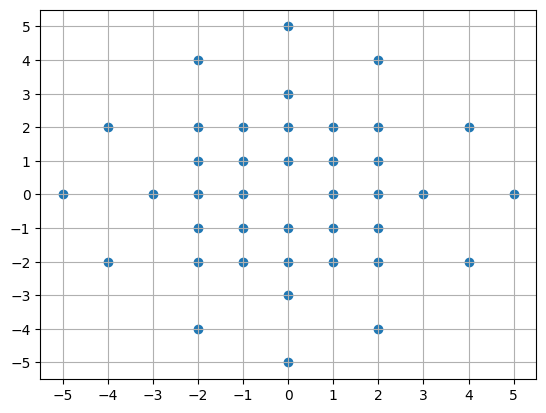

(40, 2)

In [52]:
points1 = get_grid_offsets(-2, 2)
points2 = get_clock_offsets([5, 3])
points = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(points1, points2)))))
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

In [54]:
def generate_image_offsets(image, offsets):
    sz = int(np.sqrt(image.shape[0]))
    assert sz * sz == image.shape[0]
    images = []

    for off in offsets:
        image_offed = image.reshape(sz, sz)

        # offset by x
        x = off[0]
        image_offed = np.roll(image_offed, x, axis=1)
        cols_to_wipeout = [min(x, 0) + i for i in range(abs(x))]
        image_offed[:,cols_to_wipeout] = 0

        # offset by y
        y = off[1]
        image_offed = np.roll(image_offed, y, axis=0)
        rows_to_wipeout = [min(y, 0) + i for i in range(abs(y))]
        image_offed[rows_to_wipeout,:] = 0
        
        image_offed = image_offed.reshape(-1)
        images.append(image_offed)

    return np.array(images)


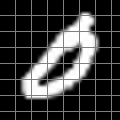
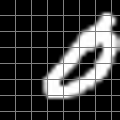
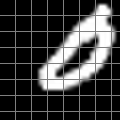
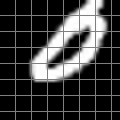
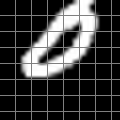
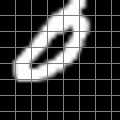
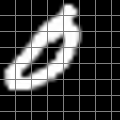
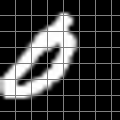
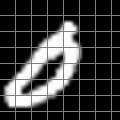
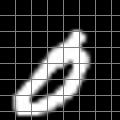
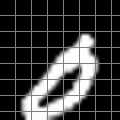
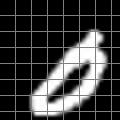
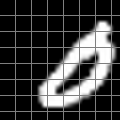
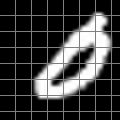
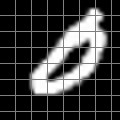
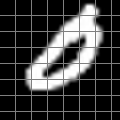
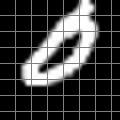
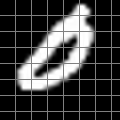
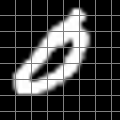
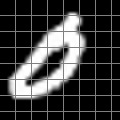
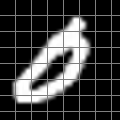
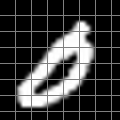
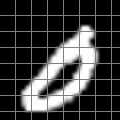
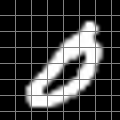
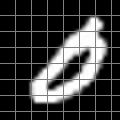
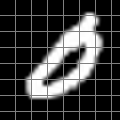
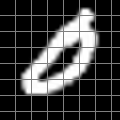
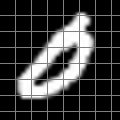
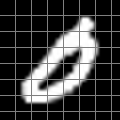

In [56]:
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
img_data = x_train[RNG.choice(len(x_train))]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)

captions = list(map(lambda x: f'x={x[0]}, y={x[1]}', xy_offsets))
display_images_grid(list(map(lambda i: lay_grid(matrix_to_image(i).resize((120, 120)), 16), image_offsets)), captions=captions, col_count=8)

In [57]:
id_offset = 0

image_indices = RNG.choice(len(x_train), 10, replace=False)
image_dataset = defaultdict(list)
image_encoding_dataset = defaultdict(list)
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])

for i in tqdm(image_indices):
    img_data = x_train[i]
    img_label = y_train[i]

    with Image.frombytes('L', size=(28, 28), data=img_data) as img:
        b = io.BytesIO()
        img = img.resize((config.sample_size, config.sample_size))
        img.save(b, format='PNG')
        png = b.getvalue()

        image_id = i + id_offset
        image_dataset['image_id'].append(image_id)
        image_dataset['value'].append(str(img_label))
        image_dataset['png'].append(png)

        image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
        image_offset_encodings = sense_images(xp.array(image_offsets))

        for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
            image_encoding_dataset['image_id'].append(image_id)
            image_encoding_dataset['offset_x'].append(x)
            image_encoding_dataset['offset_y'].append(y)
            image_encoding_dataset['data'].append(xp_array_from_gpu(ioe).astype('b'))

image_dataset = pd.DataFrame(image_dataset)
image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
;

  0%|          | 0/10 [00:00<?, ?it/s]

''

In [58]:
def create_datasets(x_dataset, y_dataset, samples_count, id_offset):
    image_indices = RNG.choice(len(x_dataset), samples_count, replace=False)
    image_dataset = defaultdict(list)
    image_encoding_dataset = defaultdict(list)

    xy_offsets_grid = get_grid_offsets(-2, 2)
    xy_offsets_clock = get_clock_offsets([5, 3])
    xy_offsets = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(xy_offsets_grid, xy_offsets_clock)))))
    xy_offsets = np.concat([[[0, 0]], xy_offsets])
    
    for i in tqdm(image_indices):
        img_data = x_dataset[i]
        img_label = y_dataset[i]
    
        with Image.frombytes('L', size=(28, 28), data=img_data) as img:
            b = io.BytesIO()
            img = img.resize((config.sample_size, config.sample_size))
            img.save(b, format='PNG')
            png = b.getvalue()
    
            image_id = i + id_offset
            image_dataset['image_id'].append(image_id)
            image_dataset['value'].append(str(img_label))
            image_dataset['png'].append(png)
    
            image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
            image_offset_encodings = sense_images(xp.array(image_offsets))
    
            for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
                image_encoding_dataset['image_id'].append(image_id)
                image_encoding_dataset['offset_x'].append(x)
                image_encoding_dataset['offset_y'].append(y)
                image_encoding_dataset['data'].append(xp_array_from_gpu(ioe).astype('b'))
    
    image_dataset = pd.DataFrame(image_dataset)
    image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
    return image_dataset, image_encoding_dataset

def save_datasets(image_dataset, image_encoding_dataset, db_con):
    image_dataset.to_sql(name='images', con=db_con)
    image_encoding_dataset.to_sql(name='image_encodings', con=db_con)

    cur = db_con.cursor()
    cur.execute('CREATE INDEX ix_images_image_id ON images(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id ON image_encodings(image_id)')       
    cur.execute('ALTER TABLE image_encodings ADD COLUMN hdv BLOB')

In [59]:
if not is_table_exists(train_db_con, 'images'):
    image_dataset, image_encoding_dataset = create_datasets(x_train, y_train, config.dataset_train_samples_count, 0)
    save_datasets(image_dataset, image_encoding_dataset, train_db_con)

if not is_table_exists(test_db_con, 'images'):
    image_dataset, image_encoding_dataset = create_datasets(x_test, y_test, config.dataset_test_samples_count, 100_000_000)
    save_datasets(image_dataset, image_encoding_dataset, test_db_con)

In [60]:
hdc = Hdc(config.hdc_n, np)

In [73]:
ENCODING_STRIDE_WIDTH = 16

def clear_image_encoding_hdvs(db_con):
    cur = db_con.cursor()
    cur.execute('UPDATE image_encodings SET hdv=NULL')
    db_con.commit()

def make_image_encoding_hdvs(db_con, stride_hdvs):
    cur = db_con.cursor()
    df_images = pd.read_sql('SELECT image_id FROM images', con=db_con)
    
    for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
        image_id = int(row['image_id'])
        df_image_encodings = pd.read_sql('SELECT "index", data FROM image_encodings WHERE image_id=:image_id AND hdv IS NULL', params={'image_id': image_id}, con=db_con)
        executemany_params = []

        for _, enc_row in df_image_encodings.iterrows():
            enc_index = int(enc_row['index'])
            encoding = np.frombuffer(enc_row['data'], dtype='b')
            encoding_stride_hdvs = []
            encoding_hdv = np.array([])
            
            for stride_index in range(0, encoding.shape[0], ENCODING_STRIDE_WIDTH):
                stride = encoding[stride_index:stride_index + ENCODING_STRIDE_WIDTH]
                stride_code = ''.join(map(str, stride.tolist()))
    
                if not stride_code.replace('0', ''): # for relatively short strides this is ~x2 faster than np.all(stride == 0) or np.max(stride) == 0
                    continue

                stride_hdv = stride_hdvs[stride_code]
                stride_hdv = hdc.shift(stride_hdv, stride_index)
                encoding_stride_hdvs.append(stride_hdv)
    
            if encoding_stride_hdvs:
                encoding_hdv = hdc.bundle(encoding_stride_hdvs)
                assert encoding_hdv.shape[0] == hdc.N, encoding_hdv.shape

            executemany_params.append({'index': enc_index, 'hdv': encoding_hdv.tobytes()})

        cur.executemany('UPDATE image_encodings SET hdv=:hdv WHERE "index"=:index', executemany_params)
    
    db_con.commit()

stride_hdvs = defaultdict(hdc)

if is_table_exists(hdv_db_con, 'stride_hdvs'):
    df_stride_hdvs = pd.read_sql('SELECT code, hdv FROM stride_hdvs', con=hdv_db_con)
    hdvs = map(lambda x: np.frombuffer(x, dtype='b'), df_stride_hdvs['hdv'])
    stride_hdvs.update(zip(df_stride_hdvs['code'], hdvs))

if 1 == 1:
    clear_image_encoding_hdvs(train_db_con)
    clear_image_encoding_hdvs(test_db_con)
    
make_image_encoding_hdvs(train_db_con, stride_hdvs)
make_image_encoding_hdvs(test_db_con, stride_hdvs)

pd.DataFrame(stride_hdvs.items(), columns=['code', 'hdv']).to_sql(name='stride_hdvs', con=hdv_db_con, if_exists='replace')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

475

In [74]:
df_image_encodings = pd.read_sql('SELECT "index", hdv FROM image_encodings WHERE "index"=0 LIMIT 1', con=train_db_con)

for enc_index, enc_row in df_image_encodings.iterrows():
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    print(len(enc_row['hdv']), hdv.shape, np.unique_counts(hdv))    

10000 (10000,) UniqueCountsResult(values=array([-1,  1], dtype=int8), counts=array([5114, 4886]))


CPU times: user 86.8 ms, sys: 16.1 ms, total: 103 ms
Wall time: 102 ms



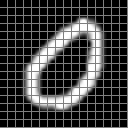
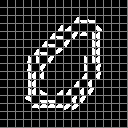
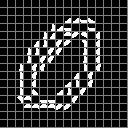
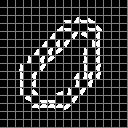
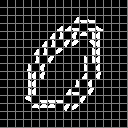
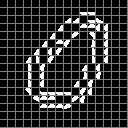
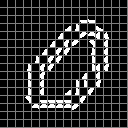
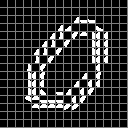
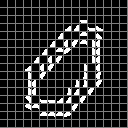
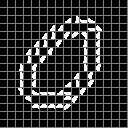
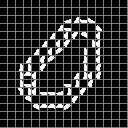
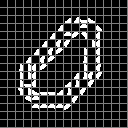
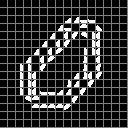
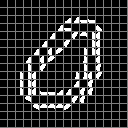
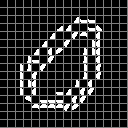
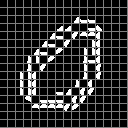
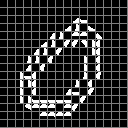
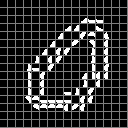
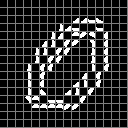
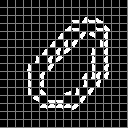
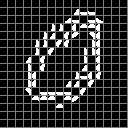
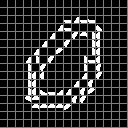
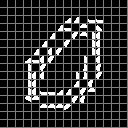
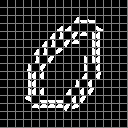
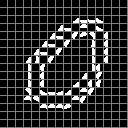
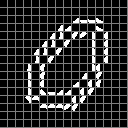
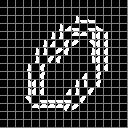
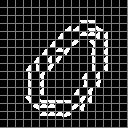
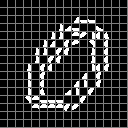
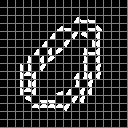
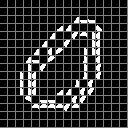
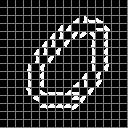
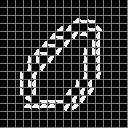
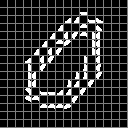
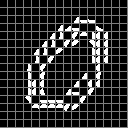
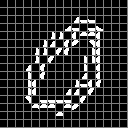
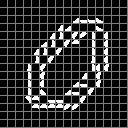
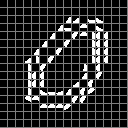
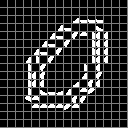
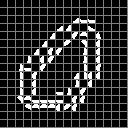
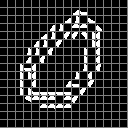
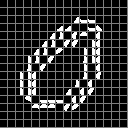

In [96]:
%%time
empty_image = Image.new('L', size=(1,1), color=255)
images = []
captions = []
col_count = 8

df_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
image_id = RNG.choice(df_images.index.unique())
image_data = df_images.loc[image_id]['png']
image = Image.open(io.BytesIO(image_data))
images.append(image)
captions.append(f'{image_id}, val={df_images.loc[image_id]['value']}')
images.extend([empty_image] * (col_count - 1))
captions.extend([''] * (col_count - 1))

df_encodings = pd.read_sql_query('SELECT * FROM image_encodings WHERE image_id = :image_id', params={'image_id': int(image_id)}, con=train_db_con)

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['data'], dtype='b')
    sensor_activations = encoding.reshape(RETINA_SIZE, RETINA_SIZE, SENSOR_GROUP_SQUARE)
    sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
    sensor_map_image = np.zeros((sz, sz))
    
    for y in range(RETINA_SIZE):
        for x in range(RETINA_SIZE):
            sensors_in_group = sensor_activations[y, x]
            assert sensors_in_group.shape == (SENSOR_GROUP_SQUARE,)
    
            if np.any(sensors_in_group > 0):
                # Find most similar reaction among specific samples of reactions
                a = sensors_in_group
                b = specific_samples_sense_ref[y, x, :]
                sense_vector_cos_sim = (a @ b)/(np.linalg.norm(a) * np.linalg.norm(b, axis=0))
                best_i = np.argmax(sense_vector_cos_sim)
                most_similar_specific_sample = SPECIFIC_SAMPLES[best_i].reshape((sz, sz))
                srfs = SENSOR_RECEPTIVE_FIELD_SIZE
                np.copyto(sensor_map_image[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

    images.append(Image.frombytes('L', (sz, sz), data=(sensor_map_image * 255).ravel().astype('b')))
    captions.append(f'offset={enc_row['offset_x']}, {enc_row['offset_y']}')

lay_grid_local = lambda i: lay_grid(i, SENSOR_RECEPTIVE_FIELD_SIZE)
display_images_grid(list(map(lay_grid_local, images)), captions=captions, col_count=col_count)